# Rendering MultibodyPlant Tutorial
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).


This shows examples of:
* Adding a `MultibodyPlant` and `SceneGraph` to a diagram
* Adding two separate IIWAs to the `MultibodyPlant`
* Adding default visualization
* Adding a camera with a VTK renderer
* Rendering color and label images (at zero configuration)
* Using `SceneGraphInspector` to query `SceneGraph` geometries
* Associating `SceneGraph` geometries with `MultibodyPlant` bodies
* Extracting `RenderLabel`s from given geometries
* Remapping labels to only distinguish by `ModelInstanceIndex`.

## Necessary Imports

In [ ]:
import copy
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [ ]:
from pydrake.geometry import (
    ClippingRange,
    ColorRenderCamera,
    DepthRange,
    DepthRenderCamera,
    MakeRenderEngineVtk,
    RenderCameraCore,
    RenderEngineVtkParams,
    RenderLabel,
    Role,
    StartMeshcat,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.tree import BodyIndex
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.sensors import (
    CameraInfo,
    RgbdSensor,
)
from pydrake.visualization import (
    AddDefaultVisualization,
    ColorizeDepthImage,
    ColorizeLabelImage,
)

We'll also start a `Meshcat` instance here.  It is typical to do this once at the beginning of the notebook, and use the same instance throughout.  You should open a second browser window to the URL that is displayed in the cell output.

In [ ]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://2b4fc509-aef2-417d-a40d-6071dfed9199.deepnoteproject.com/7003/


## Define helper methods

In [ ]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

## Create diagram builder with plant and scene graph.

In [ ]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)

In [ ]:
iiwa_url = (
   "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf"
)

## Add first IIWA on left side.

In [ ]:
(left_iiwa,) = Parser(plant, "left").AddModels(url=iiwa_url)
plant.WeldFrames(
    frame_on_parent_F=plant.world_frame(),
    frame_on_child_M=plant.GetFrameByName("iiwa_link_0", left_iiwa),
    X_FM=xyz_rpy_deg([0, -0.5, 0], [0, 0, 0]),
)

<WeldJoint name='world_welds_to_iiwa_link_0' index=7 model_instance=2>

## Add second IIWA on right side.

In [ ]:
(right_iiwa,) = Parser(plant, "right").AddModels(url=iiwa_url)
plant.WeldFrames(
    frame_on_parent_F=plant.world_frame(),
    frame_on_child_M=plant.GetFrameByName("iiwa_link_0", right_iiwa),
    X_FM=xyz_rpy_deg([0, 0.5, 0], [0, 0, 0]),
)

<WeldJoint name='world_welds_to_iiwa_link_0' index=15 model_instance=3>

## Add a free body.

In [ ]:
# Add a mesh from https://github.com/RobotLocomotion/models/ directly, without
# using the SDFormat wrapper file.
sugar_box_url = "package://drake_models/ycb/meshes/004_sugar_box_textured.obj"
(sugar_box,) = Parser(plant).AddModels(url=sugar_box_url)
sugar_box_body = plant.GetBodyByName("004_sugar_box_textured", sugar_box)
plant.SetDefaultFreeBodyPose(sugar_box_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

## Add renderer.

In [ ]:
renderer_name = "renderer"
scene_graph.AddRenderer(
    renderer_name, MakeRenderEngineVtk(RenderEngineVtkParams()))

## Add camera with same color and depth properties.

In [ ]:
# N.B. These properties are chosen arbitrarily.
intrinsics = CameraInfo(
    width=640,
    height=480,
    fov_y=np.pi/4,
)
core = RenderCameraCore(
    renderer_name,
    intrinsics,
    ClippingRange(0.01, 10.0),
    RigidTransform(),
)
color_camera = ColorRenderCamera(core, show_window=False)
depth_camera = DepthRenderCamera(core, DepthRange(0.01, 10.0))

Because we add this to `plant.world_body()`, this is a *scene-fixed* camera.

To make it a moving camera, simply add it to a body that is not anchored
against the world.

In [ ]:
world_id = plant.GetBodyFrameIdOrThrow(plant.world_body().index())
X_WB = xyz_rpy_deg([2, 0, 0.75], [-90, 0, 90])
sensor = RgbdSensor(
    world_id,
    X_PB=X_WB,
    color_camera=color_camera,
    depth_camera=depth_camera,
)

builder.AddSystem(sensor)
builder.Connect(
    scene_graph.get_query_output_port(),
    sensor.query_object_input_port(),
)

## Add depth and label colorizers.
The systems convert a depth (or label) image into a color image, so we can easily preview it.

In [ ]:
colorize_depth = builder.AddSystem(ColorizeDepthImage())
colorize_label = builder.AddSystem(ColorizeLabelImage())
colorize_label.background_color.set([0,0,0])
builder.Connect(sensor.GetOutputPort("depth_image_32f"),
                colorize_depth.GetInputPort("depth_image_32f"))
builder.Connect(sensor.GetOutputPort("label_image"),
                colorize_label.GetInputPort("label_image"))

## Finalize the plant.

In [ ]:
plant.Finalize()

## Add visualization.

Adding visualization using default settings for both `Meshcat` and `DrakeVisualizer` can be done with a single call to `AddDefaultVisualization()`.

In [ ]:
AddDefaultVisualization(builder=builder, meshcat=meshcat)

## Build the diagram.

In [ ]:
diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()

## Publish initial visualization message with default context.

In [ ]:
# TODO(eric.cousineau): Replace this with `diagram.Publish(diagram_context)`
# once all visualizers no longer use initialization events.
Simulator(diagram).Initialize()

## Render color and label images using matplotlib
Note that this uses the default labeling scheme, using `body.index()`.

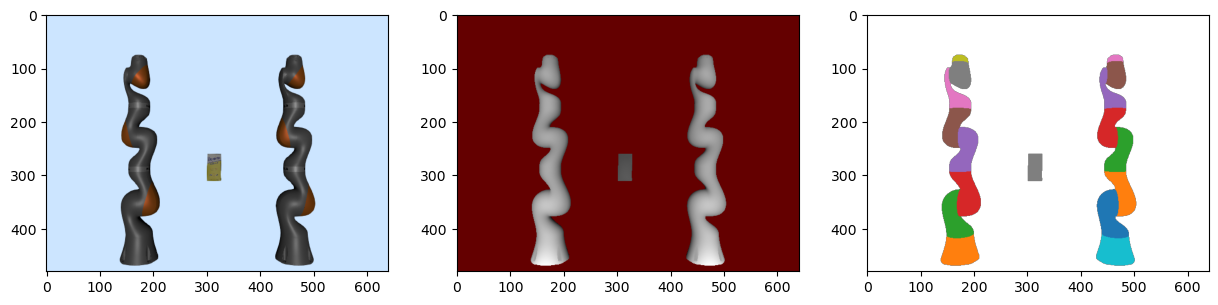

In [ ]:
color = sensor.color_image_output_port().Eval(
    sensor.GetMyContextFromRoot(diagram_context)).data
depth = colorize_depth.get_output_port().Eval(
    colorize_depth.GetMyContextFromRoot(diagram_context)).data
label = colorize_label.get_output_port().Eval(
    colorize_label.GetMyContextFromRoot(diagram_context)).data

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(color)
ax[1].imshow(depth)
ax[2].imshow(label)

## Change labels to model instance instead of body index.

We'll loop through each geometry item and change its label to reflect the model instance rather than body index.

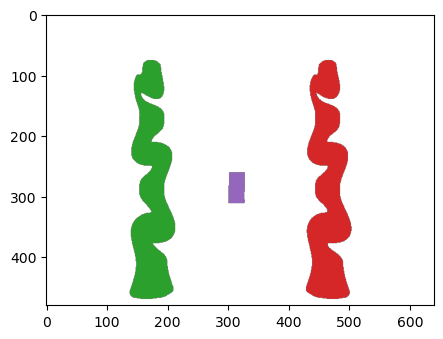

In [ ]:
source_id = plant.get_source_id()
scene_graph_context = scene_graph.GetMyMutableContextFromRoot(diagram_context)
query_object = scene_graph.get_query_output_port().Eval(scene_graph_context)
inspector = query_object.inspector()
for geometry_id in inspector.GetAllGeometryIds():
    properties = copy.deepcopy(inspector.GetPerceptionProperties(geometry_id))
    if properties is None:
        continue
    frame_id = inspector.GetFrameId(geometry_id)
    body = plant.GetBodyFromFrameId(frame_id)
    new_label = int(body.model_instance())
    properties.UpdateProperty("label", "id", RenderLabel(new_label))
    # TODO(#19123) Ideally we would use AssignRole(..., kReplace) here,
    # but it is not yet supported for perception properties.
    scene_graph.RemoveRole(scene_graph_context, source_id, geometry_id, Role.kPerception)
    scene_graph.AssignRole(scene_graph_context, source_id, geometry_id, properties)

label = colorize_label.get_output_port().Eval(
    colorize_label.GetMyContextFromRoot(diagram_context)).data
plt.figure(figsize=(5, 5))
plt.imshow(label)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=daec9c67-c271-4556-b3d6-020f0178ac09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>